In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings
warnings.filterwarnings("ignore")
                        
df = pd.read_csv('../data/Amberd_daily.csv')

df['Datetime'] = pd.to_datetime(df['Datetime'])

df.set_index('Datetime', inplace=True)
df.rename(columns={'Energy Production (kWh)': 'energy_kwh'}, inplace=True)

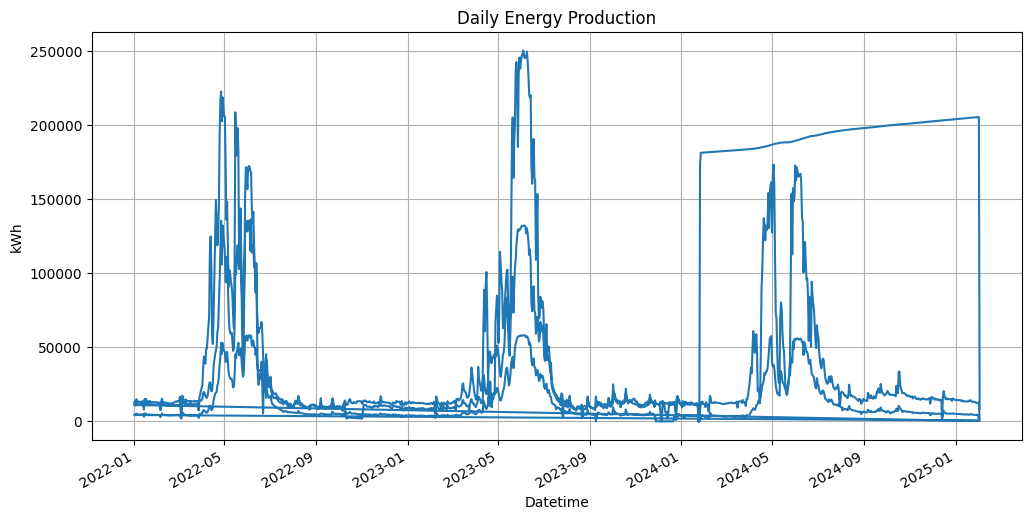


Results of Dickey-Fuller Test for All Stations:
Test Statistic            -3.786416
p-value                    0.003049
# Lags Used               28.000000
# Observations          3357.000000
Critical Value (1%)       -3.432299
Critical Value (5%)       -2.862401
Critical Value (10%)      -2.567229
dtype: float64

Results of Dickey-Fuller Test for Amberd 3:
Test Statistic            -3.718908
p-value                    0.003855
# Lags Used               16.000000
# Observations          1112.000000
Critical Value (1%)       -3.436244
Critical Value (5%)       -2.864143
Critical Value (10%)      -2.568156
dtype: float64

Results of Dickey-Fuller Test for Amberd1:
Test Statistic            -3.217727
p-value                    0.018981
# Lags Used               22.000000
# Observations          1105.000000
Critical Value (1%)       -3.436282
Critical Value (5%)       -2.864159
Critical Value (10%)      -2.568165
dtype: float64

Results of Dickey-Fuller Test for Amberd2:
Test Statistic   

In [21]:
plt.figure(figsize=(12,6))
df['energy_kwh'].plot()
plt.title('Daily Energy Production')
plt.ylabel('kWh')
plt.grid()
plt.show()

def test_stationarity(ts, name=None):
    print(f'\nResults of Dickey-Fuller Test{f" for {name}" if name else ""}:')
    dftest = adfuller(ts.dropna(), autolag='AIC')
    output = pd.Series(
        dftest[0:4],
        index=['Test Statistic','p-value','# Lags Used','# Observations']
    )
    for key, crit in dftest[4].items():
        output[f'Critical Value ({key})'] = crit
    print(output)

test_stationarity(df['energy_kwh'], name='All Stations')

for station in df['Station'].unique():
    series = df.loc[df['Station'] == station, 'energy_kwh']
    test_stationarity(series, name=station)

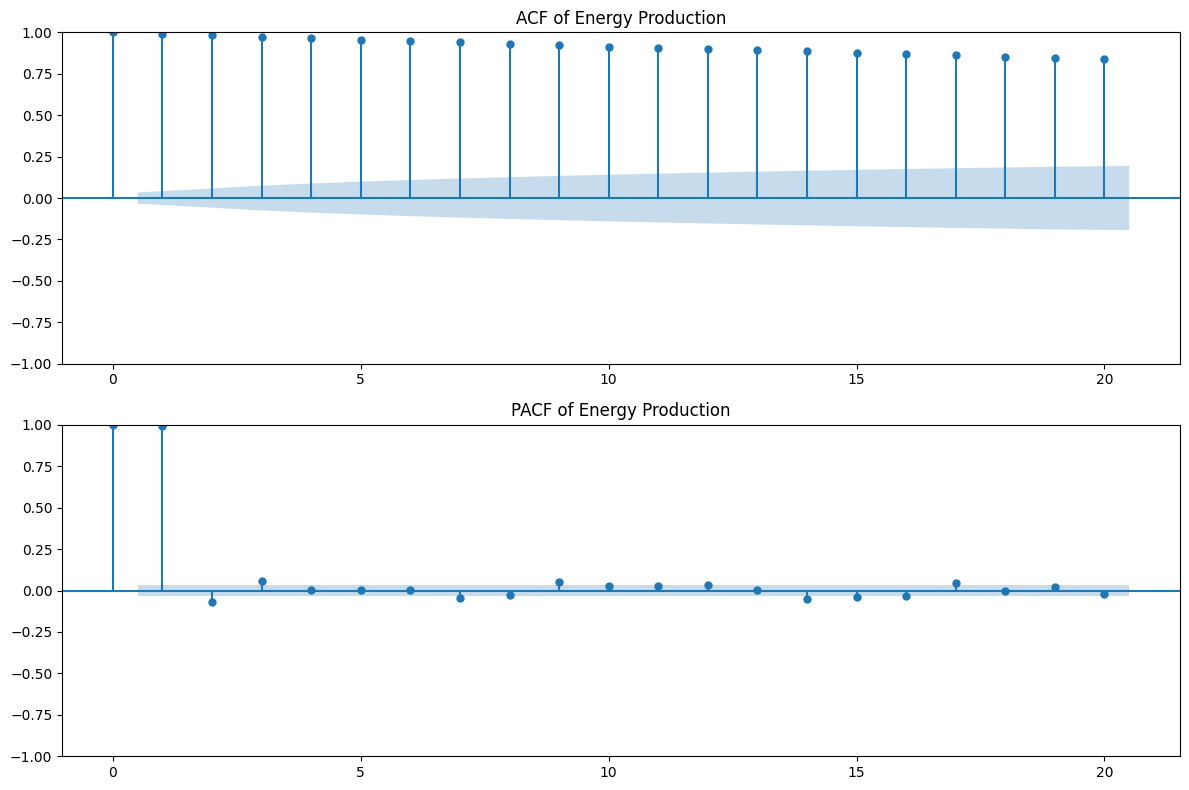

In [23]:
series = df['energy_kwh'].dropna()

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(series, lags=20, ax=ax1, title="ACF of Energy Production")
plot_pacf(series, lags=20, ax=ax2, title="PACF of Energy Production")
plt.tight_layout()
plt.show()

                                     SARIMAX Results                                     
Dep. Variable:                        energy_kwh   No. Observations:                 3386
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 7)   Log Likelihood              -35422.949
Date:                           Mon, 28 Apr 2025   AIC                          70855.898
Time:                                   17:19:22   BIC                          70886.510
Sample:                                        0   HQIC                         70866.845
                                          - 3386                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3034      0.081     -3.767      0.000      -0.461      -0.146
ma.L1          0.4359      0.080      5.452

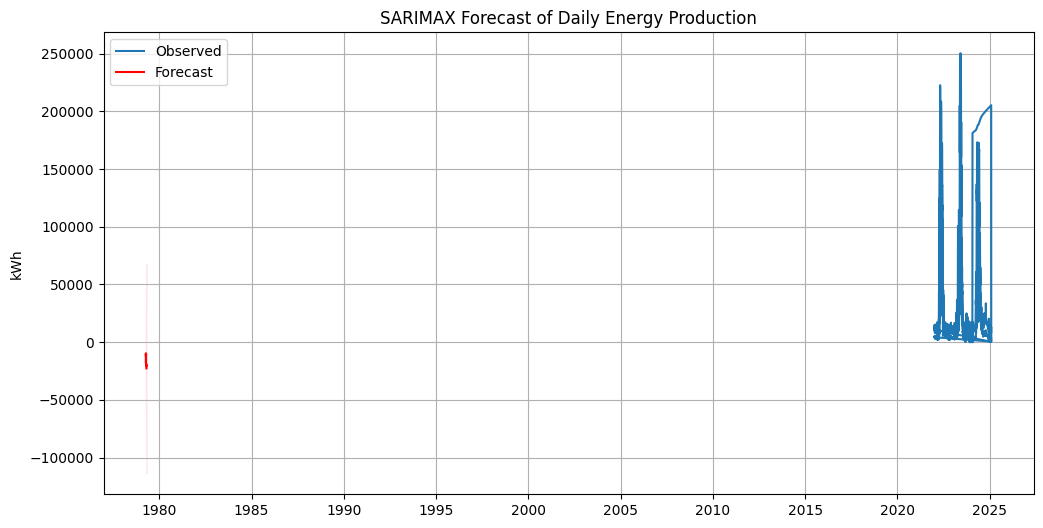

In [27]:
model = SARIMAX(
    series,
    order=(1, 1, 1),
    seasonal_order=(1, 1, 1, 7),
    enforce_stationarity=False,
    enforce_invertibility=False
)
results = model.fit(disp=False)
print(results.summary())

steps = 14
forecast_obj = results.get_forecast(steps=steps)
fc_mean = forecast_obj.predicted_mean
ci = forecast_obj.conf_int()

plt.figure(figsize=(12, 6))
plt.plot(series.index, series, label='Observed')
plt.plot(fc_mean.index,  fc_mean, color='r', label='Forecast')
plt.fill_between(
    ci.index,
    ci.iloc[:, 0],
    ci.iloc[:, 1],
    color='pink', alpha=0.3
)
plt.title('SARIMAX Forecast of Daily Energy Production')
plt.ylabel('kWh')
plt.legend()
plt.grid(True)
plt.show()

                                     SARIMAX Results                                     
Dep. Variable:                        energy_kwh   No. Observations:                 3386
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 7)   Log Likelihood              -35432.895
Date:                           Mon, 28 Apr 2025   AIC                          70887.789
Time:                                   17:24:28   BIC                          70955.135
Sample:                                        0   HQIC                         70911.871
                                          - 3386                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
dow_1        882.1093   1944.849      0.454      0.650   -2929.725    4693.943
dow_2       1599.7813   3067.860      0.521

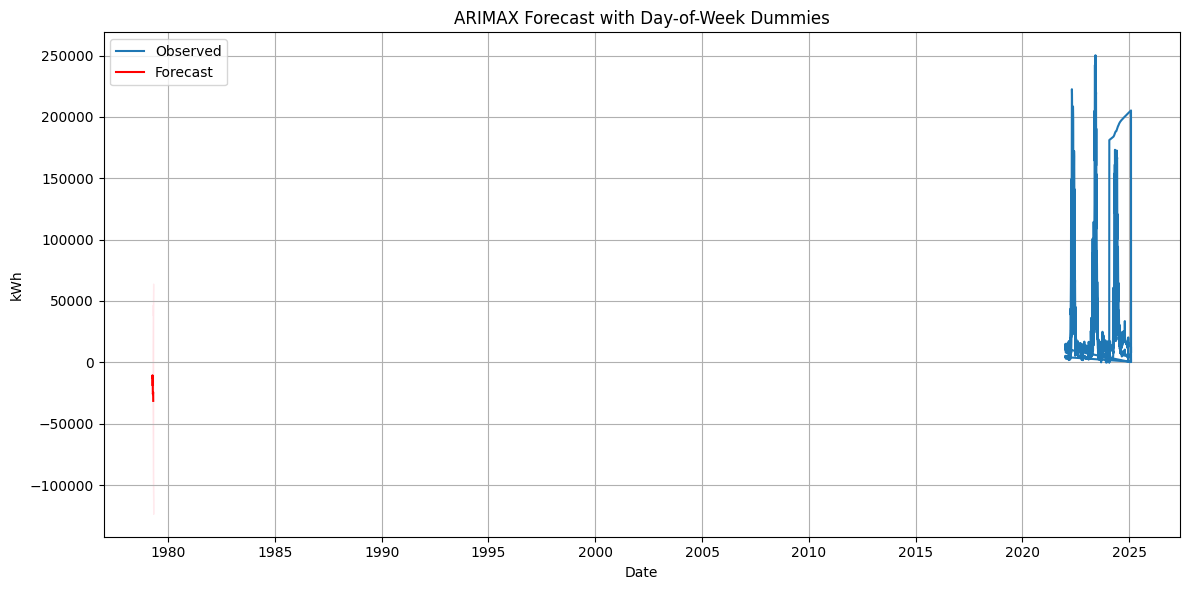

In [30]:
dow = series.index.dayofweek
exog = pd.get_dummies(dow, prefix='dow', drop_first=True, dtype=float)
exog.index = series.index

model = SARIMAX(
    series,
    exog=exog,
    order=(1,1,1),
    seasonal_order=(1,1,1,7),
    enforce_stationarity=False,
    enforce_invertibility=False
)
results = model.fit(disp=False)
print(results.summary())

steps = 14
future_idx = pd.date_range(
    start=series.index[-1] + pd.Timedelta(days=1),
    periods=steps,
    freq='D'
)
dow_future = future_idx.dayofweek
exog_future = pd.get_dummies(dow_future, prefix='dow', drop_first=True, dtype=float)
exog_future = exog_future.reindex(columns=exog.columns, fill_value=0.0)
exog_future.index = future_idx

fc = results.get_forecast(steps=steps, exog=exog_future)
fc_mean = fc.predicted_mean
ci = fc.conf_int()

plt.figure(figsize=(12,6))
plt.plot(series.index, series,         label='Observed')
plt.plot(fc_mean.index, fc_mean,       label='Forecast', color='red')
plt.fill_between(ci.index,
                 ci.iloc[:,0],
                 ci.iloc[:,1],
                 color='pink', alpha=0.3)
plt.title('ARIMAX Forecast with Day-of-Week Dummies')
plt.ylabel('kWh')
plt.xlabel('Date')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
